<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>04 - Main Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *Main Model* is proposed for the *Identifying the Human Values behind Arguments* task and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

In [6]:
from torch import cuda
from transformers import logging

DEVICE = 'cuda' if cuda.is_available() else 'cpu'


# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
import numpy as np
import os

def load_embedding_model(folder_path : str, embedding_dim : int = 50, extended_version : bool = False):
    """Load the GLOVE embeddings.

    Parameters
    ----------
    folder_path : str
        Path of the folder containing the GLOVE embeddings.
    embedding_dim : int, optional
        Embedding dimension, by default 50
    extended_version : bool, optional
        Whether to use the extendend GLOVE embeddings, covering also the OOV words of our dataset, or not, by default False.

    Returns
    -------
    GLOVE_embeddings : Dict[str, np.array]
        Dictionary mapping word types into np.array embedding vectors.
    """
    GLOVE_embeddings = []

    if not extended_version:
        file_path = os.path.join(folder_path, f'glove.6B.{embedding_dim}d.txt')
    else:
        file_path = os.path.join(folder_path, f'extended_glove.{embedding_dim}d.txt')

    with open(file_path, 'r', encoding="utf-8") as f:
        text = f.read().splitlines()
        GLOVE_embeddings += text

    GLOVE_embeddings = [line.split() for line in GLOVE_embeddings if len(line)>0]
    GLOVE_embeddings = {line[0]:np.array(line[1:],dtype=np.float32) for line in GLOVE_embeddings}

    return GLOVE_embeddings

In [8]:
embedding_dimension = 100

GLOVE_embeddings = load_embedding_model(folder_path='glove_pretrained', embedding_dim=embedding_dimension)

In [9]:
from typing import List
from collections import Counter


def create_vocabulary(texts : List[List[str]], add_padding_token : bool = True):
    """Create the vocabulary from  the given texts

    Parameters
    ----------
    texts : List[List[str]]
        Each list is a sentence, represented as a list of strings (i.e. words).
    add_padding_token : bool, optional
        Whether to add the padding token '' into the vocabulary, default True.

    Returns
    -------
    vocabulary : np.array
        Array of strings, representing the mapping from integer ids to words. 
        The first entry, i.e. index 0, is reserved for the padding: mapping 0 -> ''.
        The entries in this vocabulary are sorted by frequence in descending order: the word with index 1 is the most 
        frequent word.
    texts_ids : List[List[int]]
        It is equal to `texts`, but each word is replaced with the corresponding integer id.

    """
    texts_flat = [word for text in texts for word in text]
    tokens = np.array(list(Counter(texts_flat).keys())) 
    tokens_counts = list(Counter(texts_flat).values()) 
    tokens = tokens[np.argsort(tokens_counts)][::-1]

    if add_padding_token:
        vocabulary = np.array([''] +  list(tokens)) 
    else:
        vocabulary = tokens

    word2id = {word:id for id, word in enumerate(vocabulary)}

    texts_ids = [[word2id[word] for word in text] for text in texts]

    return vocabulary, texts_ids

In [10]:
texts=list(arguments_train_df['Conclusion'])+list(arguments_train_df['Premise'])
texts+=list(arguments_val_df['Conclusion'])+list(arguments_val_df['Premise'])
texts+=list(arguments_test_df['Conclusion'])+list(arguments_test_df['Premise'])
texts=[text.split() for text in texts]+[['[FAV]'], ['[AGN]']]
vocabulary, x = create_vocabulary(texts)

In [11]:
len(vocabulary)

14639

In [12]:
def build_embedding_matrix(vocabulary : List[str], GLOVE_embeddings : dict, embedding_dimension : int = 50):
    """Build the embedding matrix from the given vocabulary and the GLOVE embeddings,

    Parameters
    ----------
    vocabulary : List[str]
        List of strings, representing the vocabulary: mapping integers -> word types.
    GLOVE_embeddings : dict
        Dictionary mapping word types into embedding vectors.
    embedding_dimension : int, optional
        Dimension of the embedding, by default 50

    Returns
    -------
    embedding_matrix : np.array
        The rows are the word integers (given by `vocabulary`), and each row represents the embedding vector of that 
        corresponding word.
    """
    embedding_matrix = np.zeros((len(vocabulary), embedding_dimension), dtype=np.float32)
    for idx, word in enumerate(vocabulary):
        try:
            embedding_vector = GLOVE_embeddings[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector  

    return embedding_matrix

In [13]:
embedding_matrix = build_embedding_matrix(vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings, 
                                          embedding_dimension=embedding_dimension)

In [14]:
tokenizer={word:i for i, word in enumerate(vocabulary)}

In [15]:
tokenizer['desired']

9688

In [16]:
import torch
class LSTM_model(torch.nn.Module):
    
    def __init__(self, embedding_matrix, out_size=20, hidden_size=128, num_layers=2) -> None:
        super().__init__()

        self.embedding_l=torch.nn.Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1])#.from_pretrained(embedding_matrix)
        self.lstm_l=torch.nn.LSTM(input_size = embedding_matrix.shape[1],
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              batch_first = True)
        self.fc_l=torch.nn.Linear(hidden_size, out_size)

    class Output:
        def __init__(self, logits):
            self.logits = logits

    def forward(self, x, mask=None):
        del mask
        x = self.embedding_l(x)
        _,(_,x) = self.lstm_l(x)
        x=x[-1]
        x=self.fc_l(x)
        return LSTM_model.Output(x)

In [17]:
x=[[tokenizer[word] for word in texts[0]]]
x

[[4, 1, 37, 311]]

In [18]:
model=LSTM_model(torch.tensor(embedding_matrix))

In [19]:
model(torch.tensor(x)).logits

tensor([[ 0.0526,  0.0406,  0.0236, -0.0888, -0.0153, -0.0892, -0.1428, -0.0336,
         -0.0461,  0.0148, -0.0509, -0.0090,  0.0146,  0.1101,  0.0710,  0.0969,
         -0.0202, -0.0888,  0.0147, -0.0307]], grad_fn=<AddmmBackward0>)

In [20]:
from random import sample
from typing import Dict, List, Tuple
from transformers import AutoTokenizer

def _collate_batch(batch: Tuple[Tuple[str, str, str, List[np.ndarray[int]]]],
                   tokenizer: AutoTokenizer,
                   augment_data: bool = False) -> Dict[str, torch.Tensor]:
    """Function to transforms a minibatch of samples into a format useful for
    the training procedure.

    Parameters
    ----------
    batch : tuple of (str, str, str, list of int)
        The input minibatch.
    tokenizer : AutoTokenizer
        The autotokenizer to encode the input data.
    augment_data : bool, optional
        Whether to augment the data or not, by default False.

    Returns
    -------
    { 'ids': Tensor, 'mask': Tensor, 'labels': Tensor }
        Dictionary of tensors containing the encoded ids of the minibatch,
        their attention masks and the respective labels.
    """
    # Create a numpy matrix for the input texts and the labels
    #input_texts = np.zeros(shape=(len(batch),), dtype=object)
    inputs = []
    labels = np.zeros(shape=(len(batch), len(batch[0][3])))

    for i, (p, c, w, l) in enumerate(batch):
        # Get random text among <premise>, <conclusion> and
        # '<premise> [FAV]/[AGN] <conclusion>'
        if augment_data:
            [result] = sample([p, c, w], 1)
        # If no data augmentation is required get
        # '<premise> [FAV]/[AGN] <conclusion>'
        else:
            result = w
        # Assign to the matrices at the given index the text and the labels
        input_texts = result

        inputs.append(np.array([tokenizer[word] for word in input_texts.split()]))
        labels[i] = l

    max_len = np.max([len(sequence) for sequence in inputs])
    inputs = [torch.tensor(np.concatenate([sequence, np.zeros(max_len-len(sequence))])) for sequence in inputs]
    ids = torch.stack(inputs)
    mask=torch.ones_like(ids)

    # Get the results in a dictionary.
    return {
        'ids': ids,
        'mask':mask,
        'labels': torch.tensor(labels, dtype=torch.float32)
    }

In [21]:
from src.datasets.dataloader_builder import HumanValueDataset
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}
dataset_train = HumanValueDataset(arguments_train_df, labels_train_df, stance_encoder)
dataset_val = HumanValueDataset(arguments_val_df, labels_val_df, stance_encoder)
dataset_test = HumanValueDataset(arguments_test_df, labels_test_df, stance_encoder)

train_loader = DataLoader(dataset_train, num_workers=0, shuffle=True, batch_size=BATCH_SIZE_TRAIN,
                        collate_fn=lambda x: _collate_batch(x, tokenizer,augment_data=True))
val_loader = DataLoader(dataset_val, num_workers=0, shuffle=True, batch_size=BATCH_SIZE_EVAL,
                        collate_fn=lambda x: _collate_batch(x, tokenizer,augment_data=False))
test_loader = DataLoader(dataset_test, num_workers=0, shuffle=True, batch_size=BATCH_SIZE_EVAL,
                        collate_fn=lambda x: _collate_batch(x, tokenizer,augment_data=False))

## Training

### Create Dataloaders

### Training parameters

In [22]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss

# Set the number of epochs.
EPOCHS = 20
# Set the learning rates for the Bert model and the Classification head.
LEARNING_RATE_BERT = 1e-05
LEARNING_RATE_CLASSIFIER = 1e-03
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df))
train_labels_frequencies = train_labels_frequencies.to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Set the optimizer.
optimizer = Adam(model.parameters())

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models', 'main_model.pth'))
early_stopping = EarlyStopping()

### Training

In [23]:
tokenizer['desired']

9688

In [24]:
model=model.to(DEVICE)

In [25]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE,
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=True)

epoch: 1/20, 199/540, 1s 6ms/step, loss: 0.0643                
validate: 0s, validation loss: 0.0637, validation f1 macro: 28 %                
epoch: 1/20, 399/540, 2s 5ms/step, loss: 0.064                 
validate: 0s, validation loss: 0.0635, validation f1 macro: 28 %                
epoch: 1/20, 540/540, 3s 5ms/step, loss: 0.0638                
---------------------------------------------------------------
epoch: 1/20, 3s, loss: 0.0638, val loss:, 0.0633, val f1 macro: 28.2 %
epoch: 2/20, 199/540, 1s 4ms/step, loss: 0.0633                
validate: 0s, validation loss: 0.0633, validation f1 macro: 28.4 %                
epoch: 2/20, 399/540, 2s 4ms/step, loss: 0.0634                
validate: 0s, validation loss: 0.0632, validation f1 macro: 30.6 %                
epoch: 2/20, 540/540, 2s 5ms/step, loss: 0.0632                
---------------------------------------------------------------
epoch: 2/20, 2s, loss: 0.0632, val loss:, 0.0605, val f1 macro: 35.5 %
epoch: 3/20, 199/5

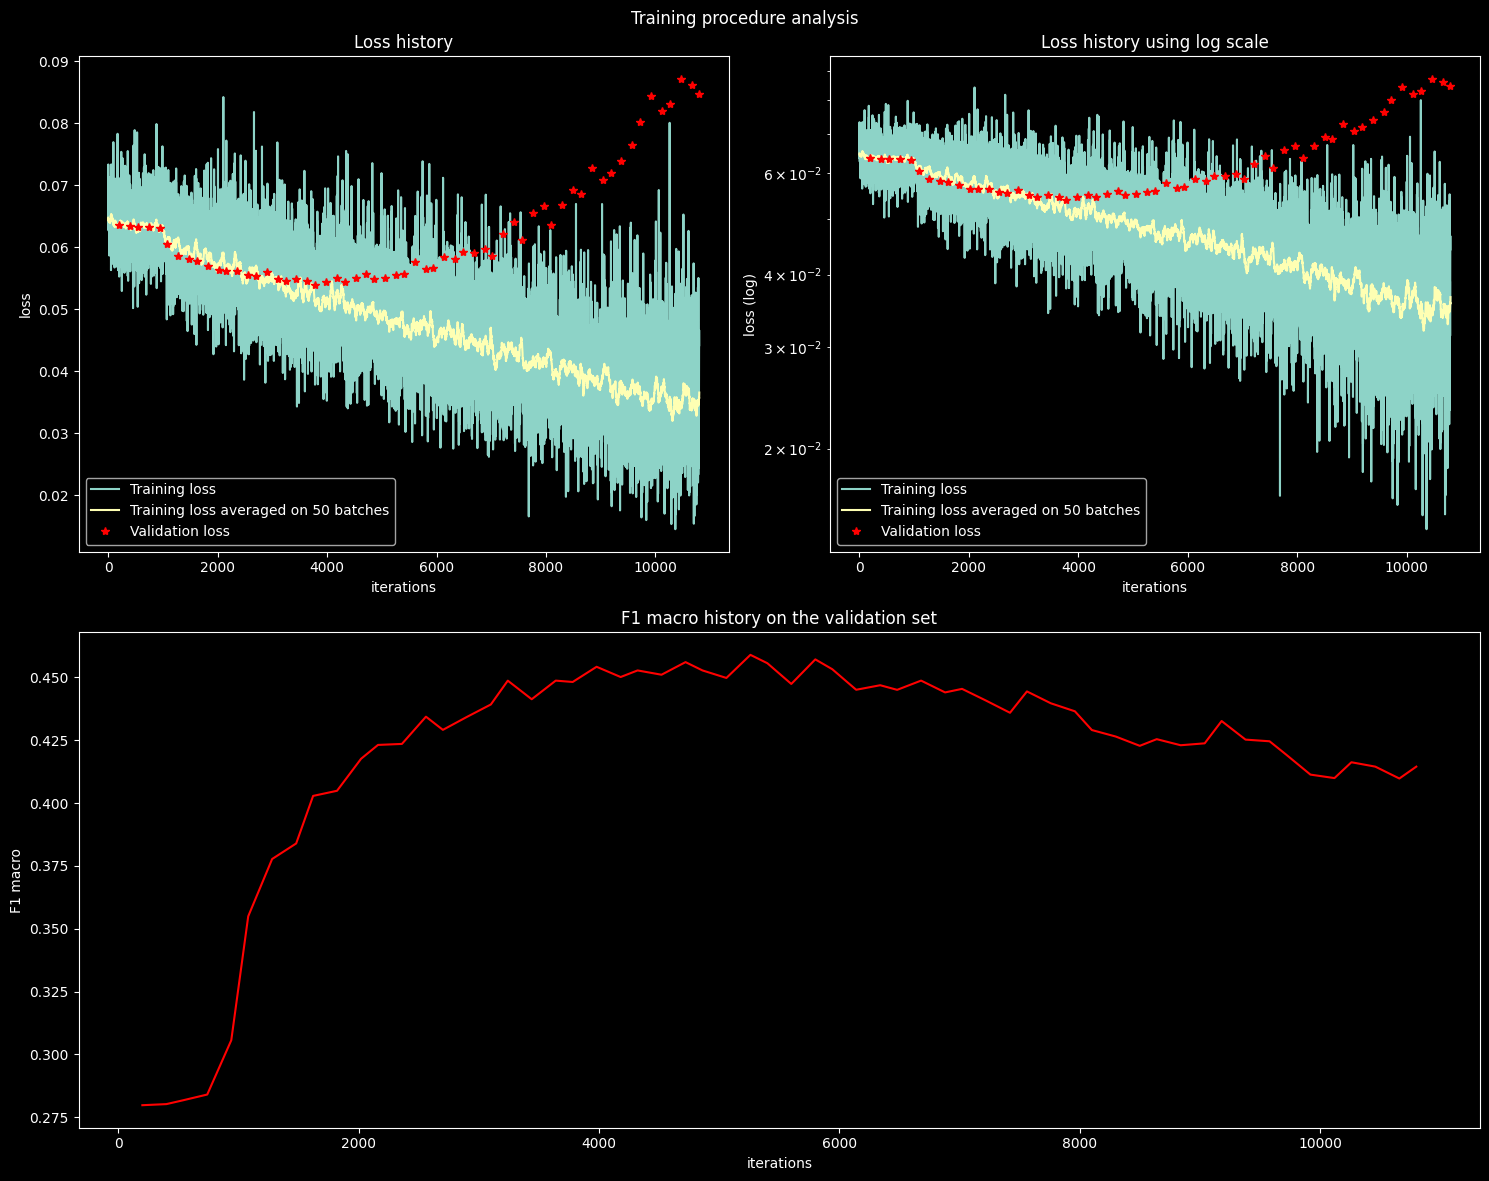

In [26]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

In [27]:
'''import torch

checkpoint = torch.load('models/main_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']'''

"import torch\n\ncheckpoint = torch.load('models/main_model.pth')\n\n# Get loss history and validation loss history\nmodel.load_state_dict(checkpoint['model_state_dict'])\ntrain_loss_history = checkpoint['train_loss_history']\nval_loss_history = checkpoint['val_loss_history']\nval_f1_macro_history = checkpoint['val_f1_macro_history']"

# Model Evaluation

## Threshold selection

In [73]:
from src.evaluation.evaluation import get_dataset_prediction_scores
import pandas as pd

# Concatenate the train and validation datasets together.
# train_and_val_loader = get_dataloader(
#     pd.concat([arguments_train_df, arguments_val_df], 
#               ignore_index=True, sort=False),
#     pd.concat([labels_train_df, labels_val_df],
#               ignore_index=True, sort=False), 
#     tokenizer, stance_encoder, batch_size=16, shuffle=False,
#     use_augmentation=False)

dataset_train_val = HumanValueDataset(pd.concat([arguments_train_df, arguments_val_df], ignore_index=True, sort=False),
                                    pd.concat([labels_train_df, labels_val_df], ignore_index=True, sort=False),
                                    stance_encoder)

train_and_val_loader = DataLoader(dataset_train_val, num_workers=0, shuffle=True, batch_size=BATCH_SIZE_TRAIN,
                        collate_fn=lambda x: _collate_batch(x, tokenizer,augment_data=False))

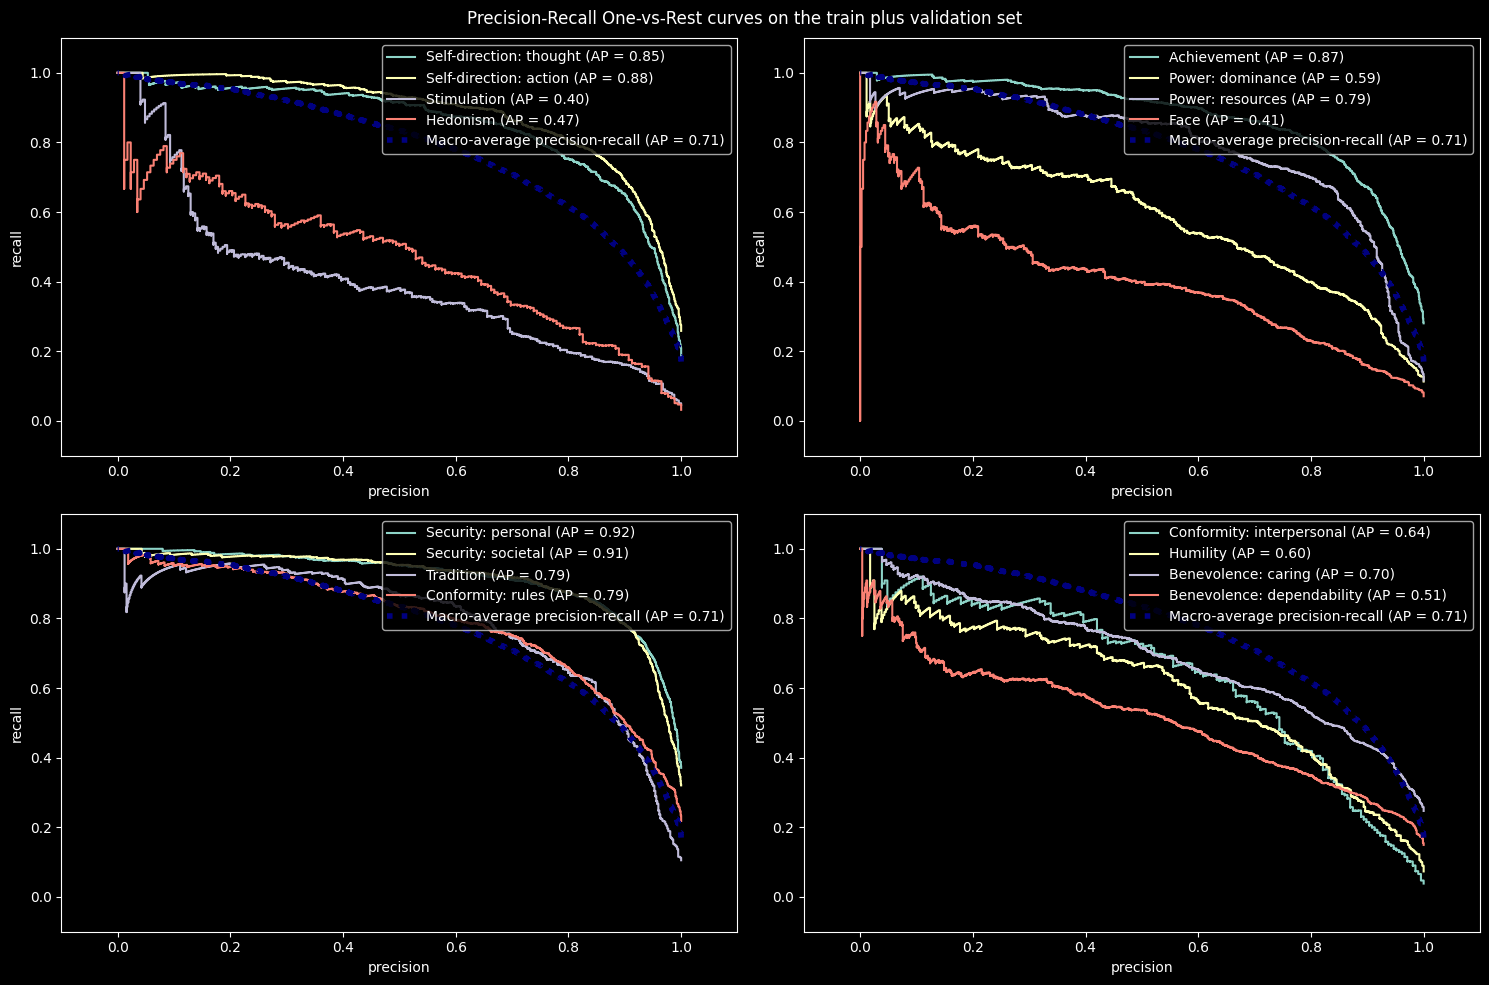

In [74]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import (
    get_precision_recall_statistics, plot_precision_recall_curves)

y_scores, y_true = get_dataset_prediction_scores(model, train_and_val_loader,
                                                 DEVICE)

precision, recall, average_precision = get_precision_recall_statistics(
    y_true, y_scores, TARGETS)

plot_precision_recall_curves(precision, recall, average_precision, TARGETS,
                             'train plus validation')

In [75]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: 0.5101
"Self-direction: action" best threshold: 0.2076
"Stimulation" best threshold: 0.6938
"Hedonism" best threshold: 1.4319
"Achievement" best threshold: 0.2505
"Power: dominance" best threshold: 0.3196
"Power: resources" best threshold: 0.3570
"Face" best threshold: 0.6045
"Security: personal" best threshold: 0.1940
"Security: societal" best threshold: 0.2606
"Tradition" best threshold: 0.6511
"Conformity: rules" best threshold: 0.2731
"Conformity: interpersonal" best threshold: 1.3206
"Humility" best threshold: 0.8165
"Benevolence: caring" best threshold: 0.1163
"Benevolence: dependability" best threshold: 0.3838
"Universalism: concern" best threshold: 0.0440
"Universalism: nature" best threshold: 1.0446
"Universalism: tolerance" best threshold: 0.5564
"Universalism: objectivity" best threshold: 0.4878


In [76]:
import torch
from src.evaluation.evaluation import get_dataset_prediction_scores

In [77]:
preds, y_true = get_dataset_prediction_scores(model, train_and_val_loader, DEVICE)

preds = torch.tensor(preds)
y_true = torch.tensor(y_true)

# Argsort elements by non decreasing values of each column (prediction of a specific target)
idx = torch.argsort(preds, 0)

# Sort predictions and true labels based on argsort
s_preds = torch.gather(preds, 0, idx)
s_true = torch.gather(y_true, 0, idx)

In [78]:
# Cumulative sum of total positive and negative instances

c_positive = torch.cumsum(s_true, 0)
c_negative = torch.cumsum(1 - s_true, 0)

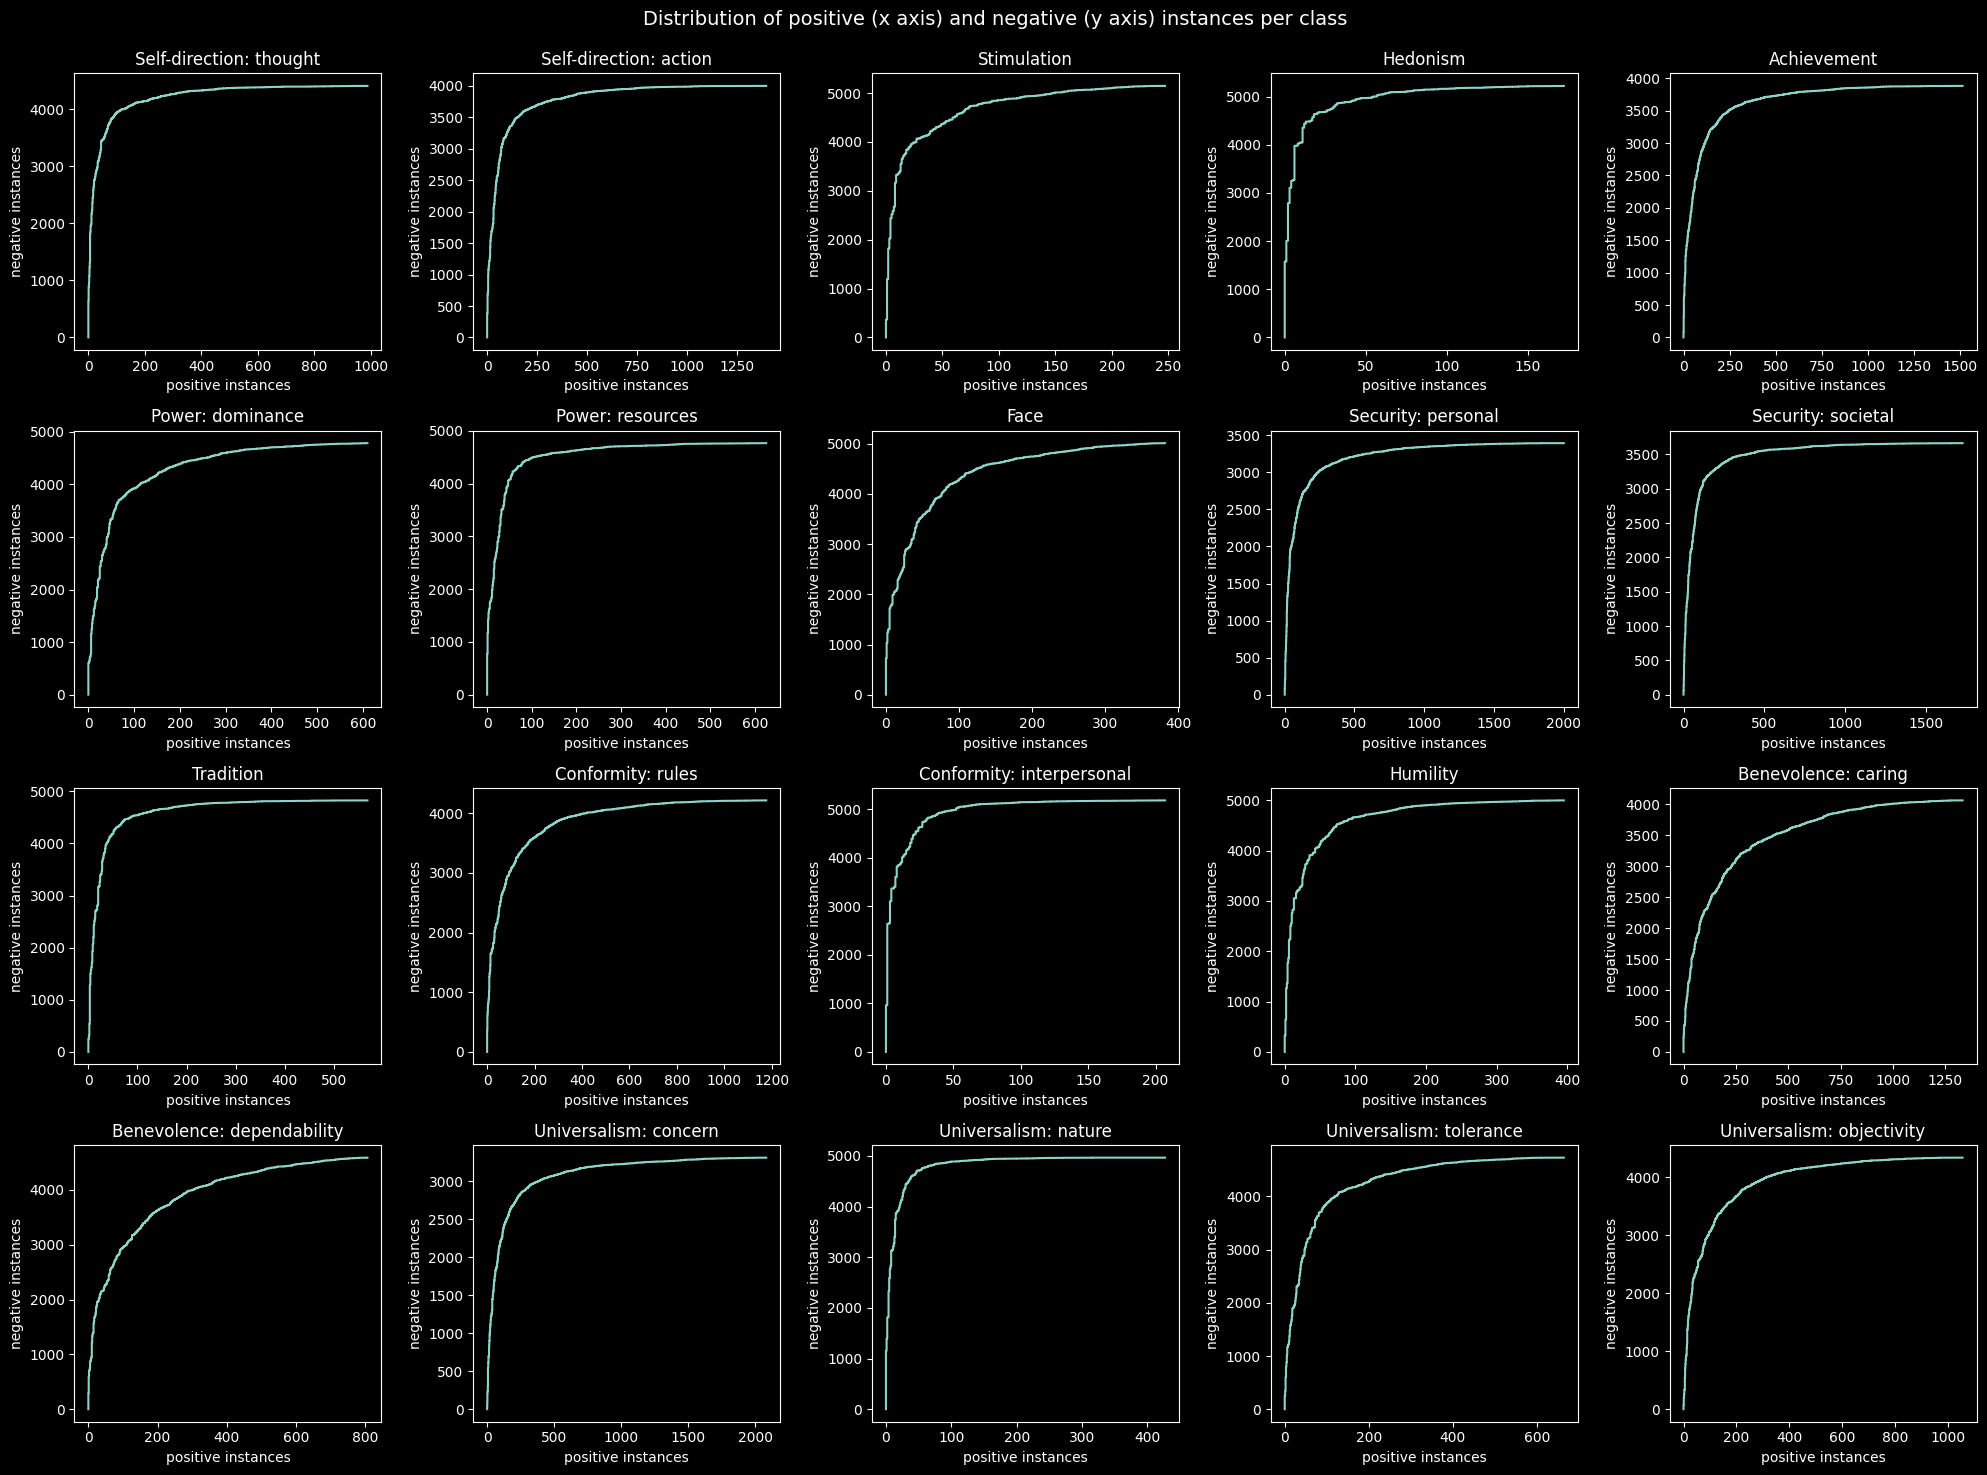

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.suptitle('Distribution of positive (x axis) and negative (y axis) instances per class\n', size=14)
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5 , i + 1)
    ax.set_title(l)
    ax.set_xlabel('positive instances')
    ax.set_ylabel('negative instances')
    ax.plot(c_positive[:,i], c_negative[:,i])
plt.tight_layout()
plt.show()

In [80]:
# Cumulative sum of true positive elements for each class at 
c_true_positive = c_positive[-1:] - c_positive

R = (torch.arange(len(c_true_positive)) + 1)[:, None]
c_precision = c_true_positive / (R[-1] - R + 1) + 1e-7
c_recall = c_true_positive / (c_true_positive[:1] + 1e-7) + 1e-7
c_F1 = 2 * (c_precision * c_recall) / (c_precision + c_recall)

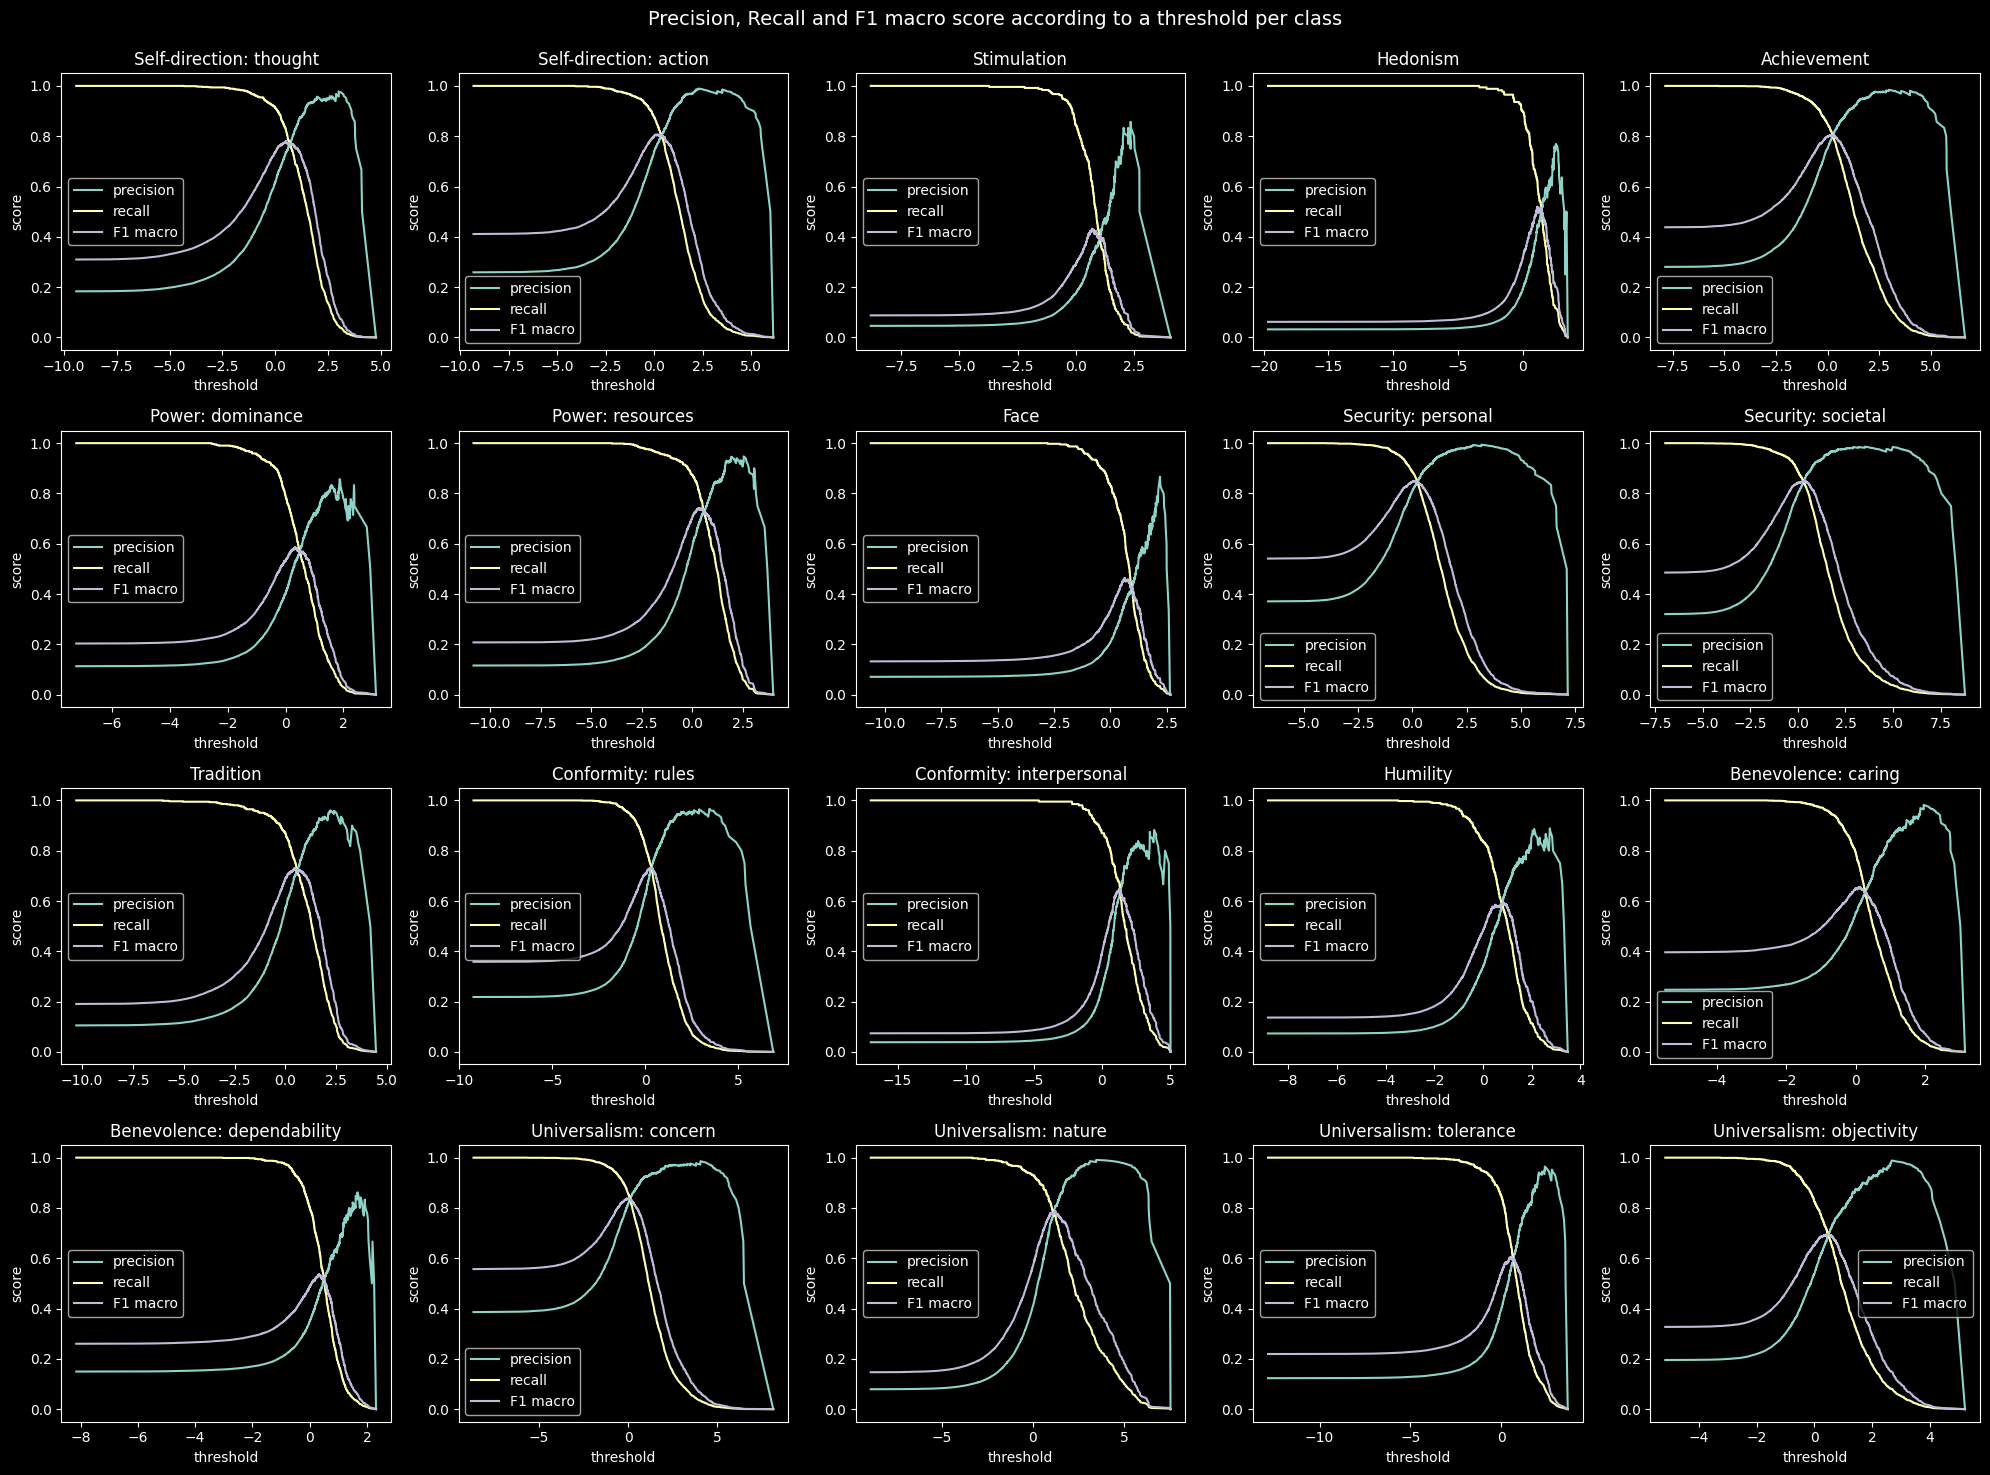

In [81]:
plt.figure(figsize=(20, 15))
plt.suptitle('Precision, Recall and F1 macro score according to a threshold per class\n', size=14)
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5, i + 1)
    ax.set_title(l)
    # TODO: Use sigmoid for threshold or not?
    ax.plot(s_preds[:,i], c_precision[:,i], label='precision')
    ax.plot(s_preds[:,i], c_recall[:,i], label='recall')
    ax.plot(s_preds[:,i], c_F1[:,i], label='F1 macro')
    ax.set_xlabel('threshold')
    ax.set_ylabel('score')
    #ax.set_xlim(0, 1)
    ax.legend()
plt.tight_layout()
plt.show()

In [82]:
import numpy as np

# Get the index of maximum F1 macro score for each target
idx_max = c_F1.argmax(0)
# Get the threshold for each target
thresholds_per_target = np.array([s_preds[idx, i] for i, idx in enumerate(idx_max)])

# Threshold selection just on the validation

In [86]:
y_scores, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)

In [87]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: 0.4813
"Self-direction: action" best threshold: -0.1376
"Stimulation" best threshold: 0.5710
"Hedonism" best threshold: 1.0125
"Achievement" best threshold: -0.3596
"Power: dominance" best threshold: -0.2196
"Power: resources" best threshold: 0.2746
"Face" best threshold: 0.6342
"Security: personal" best threshold: -0.4414
"Security: societal" best threshold: -0.4733
"Tradition" best threshold: 0.1659
"Conformity: rules" best threshold: -0.2704
"Conformity: interpersonal" best threshold: 0.9930
"Humility" best threshold: 1.1750
"Benevolence: caring" best threshold: -0.7248
"Benevolence: dependability" best threshold: 0.3514
"Universalism: concern" best threshold: -0.4753
"Universalism: nature" best threshold: 0.9611
"Universalism: tolerance" best threshold: 0.4773
"Universalism: objectivity" best threshold: -0.4987


In [88]:
import torch
from src.evaluation.evaluation import get_dataset_prediction_scores

In [89]:
preds, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)

preds = torch.tensor(preds)
y_true = torch.tensor(y_true)

# Argsort elements by non decreasing values of each column (prediction of a specific target)
idx = torch.argsort(preds, 0)

# Sort predictions and true labels based on argsort
s_preds = torch.gather(preds, 0, idx)
s_true = torch.gather(y_true, 0, idx)

In [90]:
# Cumulative sum of total positive and negative instances

c_positive = torch.cumsum(s_true, 0)
c_negative = torch.cumsum(1 - s_true, 0)

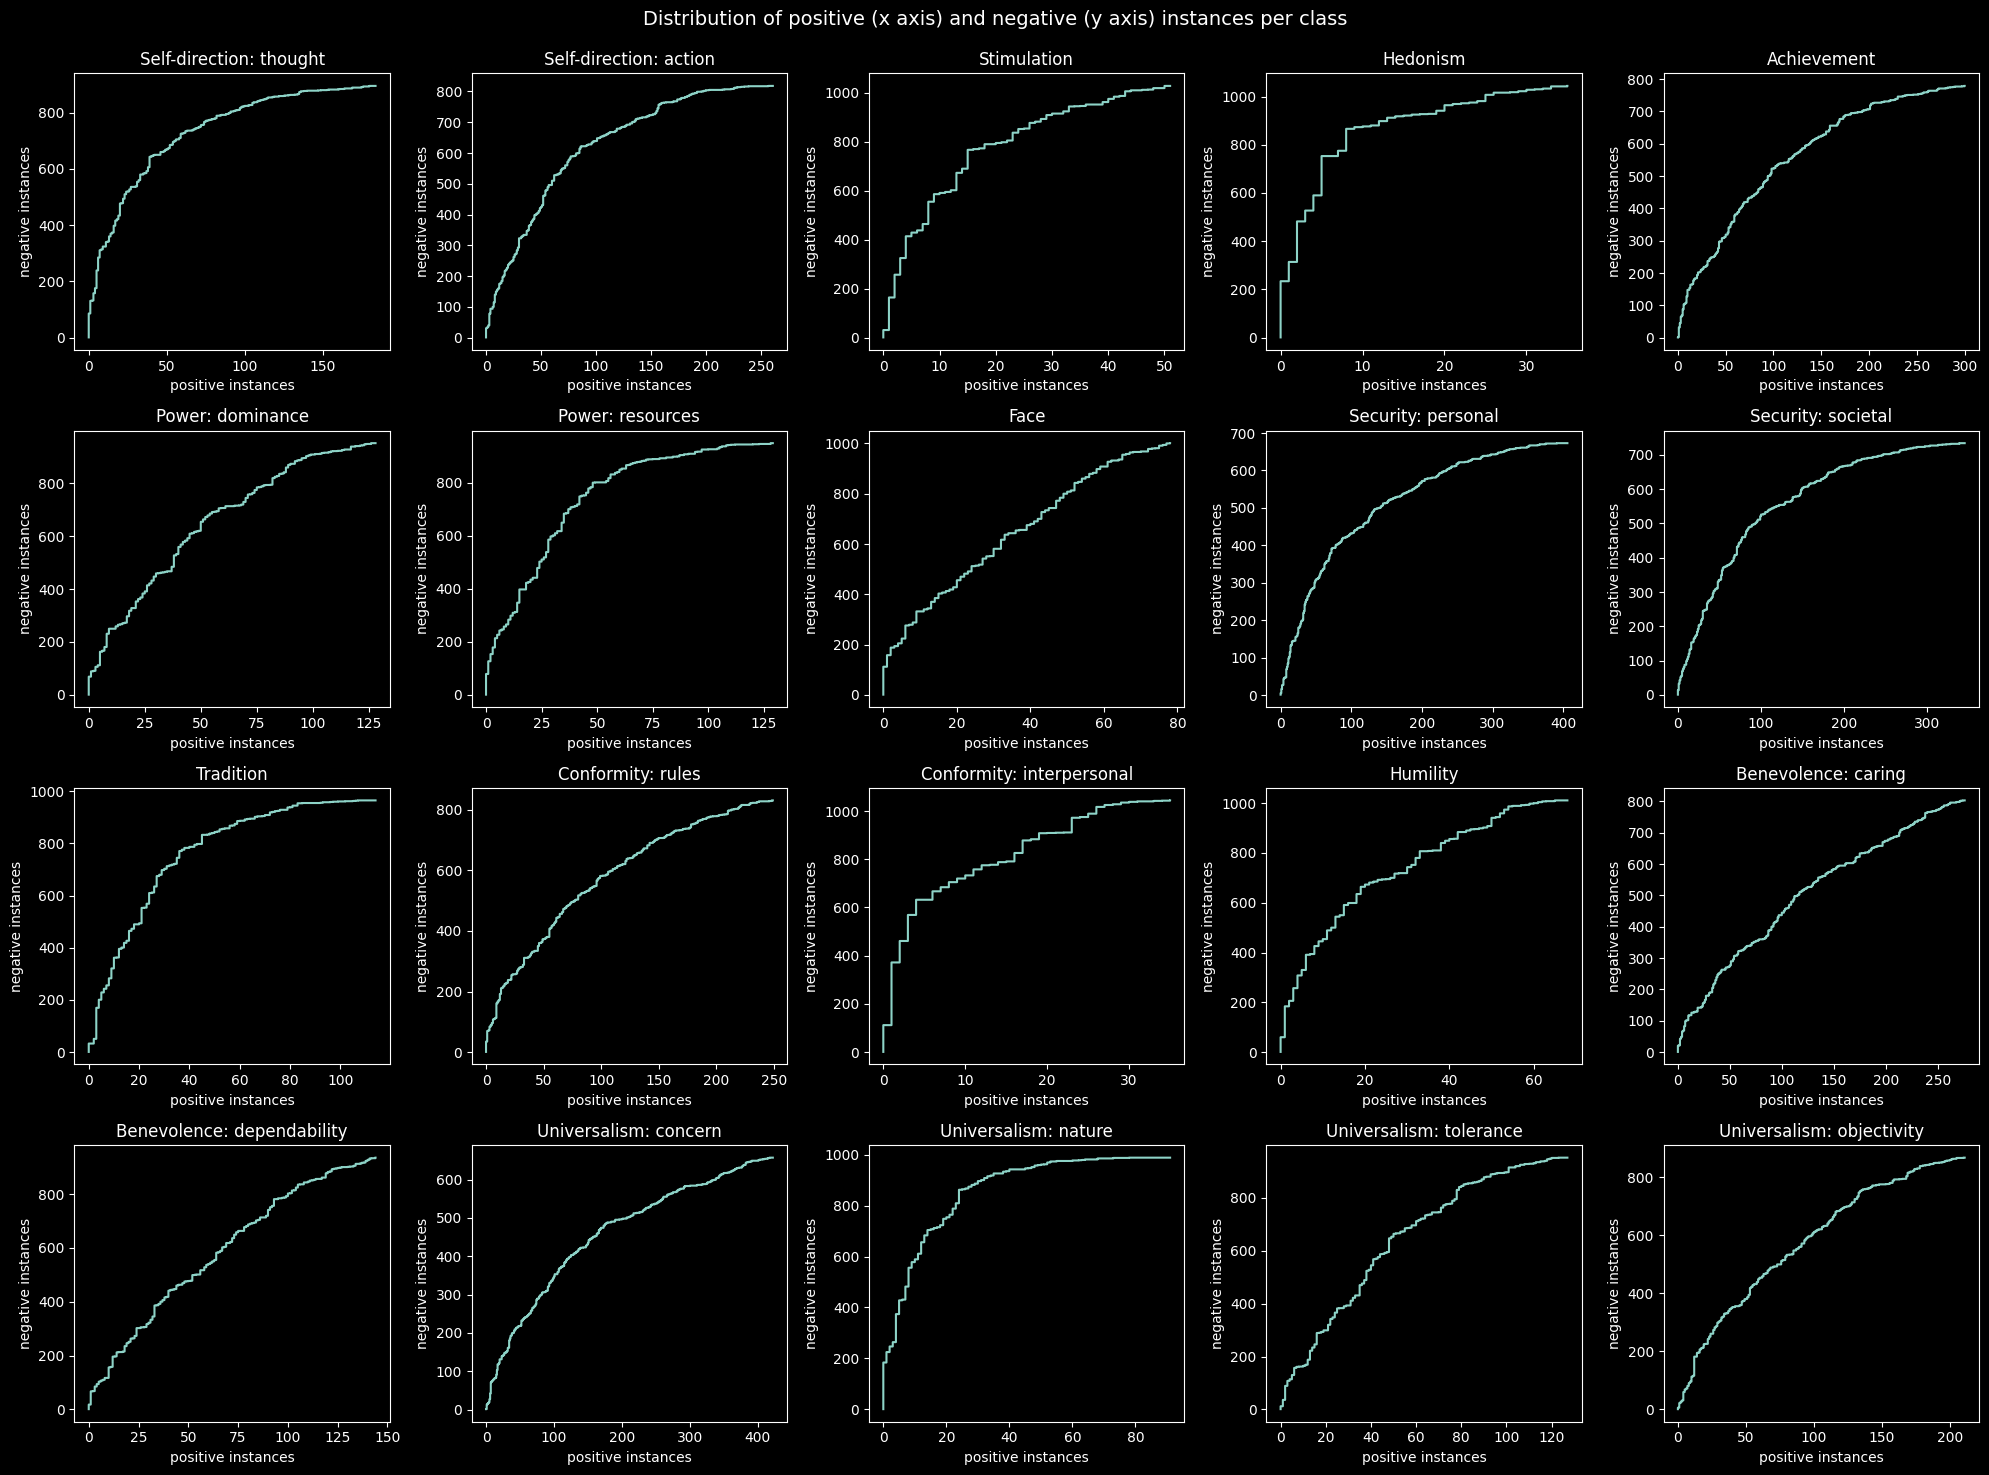

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.suptitle('Distribution of positive (x axis) and negative (y axis) instances per class\n', size=14)
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5 , i + 1)
    ax.set_title(l)
    ax.set_xlabel('positive instances')
    ax.set_ylabel('negative instances')
    ax.plot(c_positive[:,i], c_negative[:,i])
plt.tight_layout()
plt.show()

In [92]:
# Cumulative sum of true positive elements for each class at 
c_true_positive = c_positive[-1:] - c_positive

R = (torch.arange(len(c_true_positive)) + 1)[:, None]
c_precision = c_true_positive / (R[-1] - R + 1) + 1e-7
c_recall = c_true_positive / (c_true_positive[:1] + 1e-7) + 1e-7
c_F1 = 2 * (c_precision * c_recall) / (c_precision + c_recall)

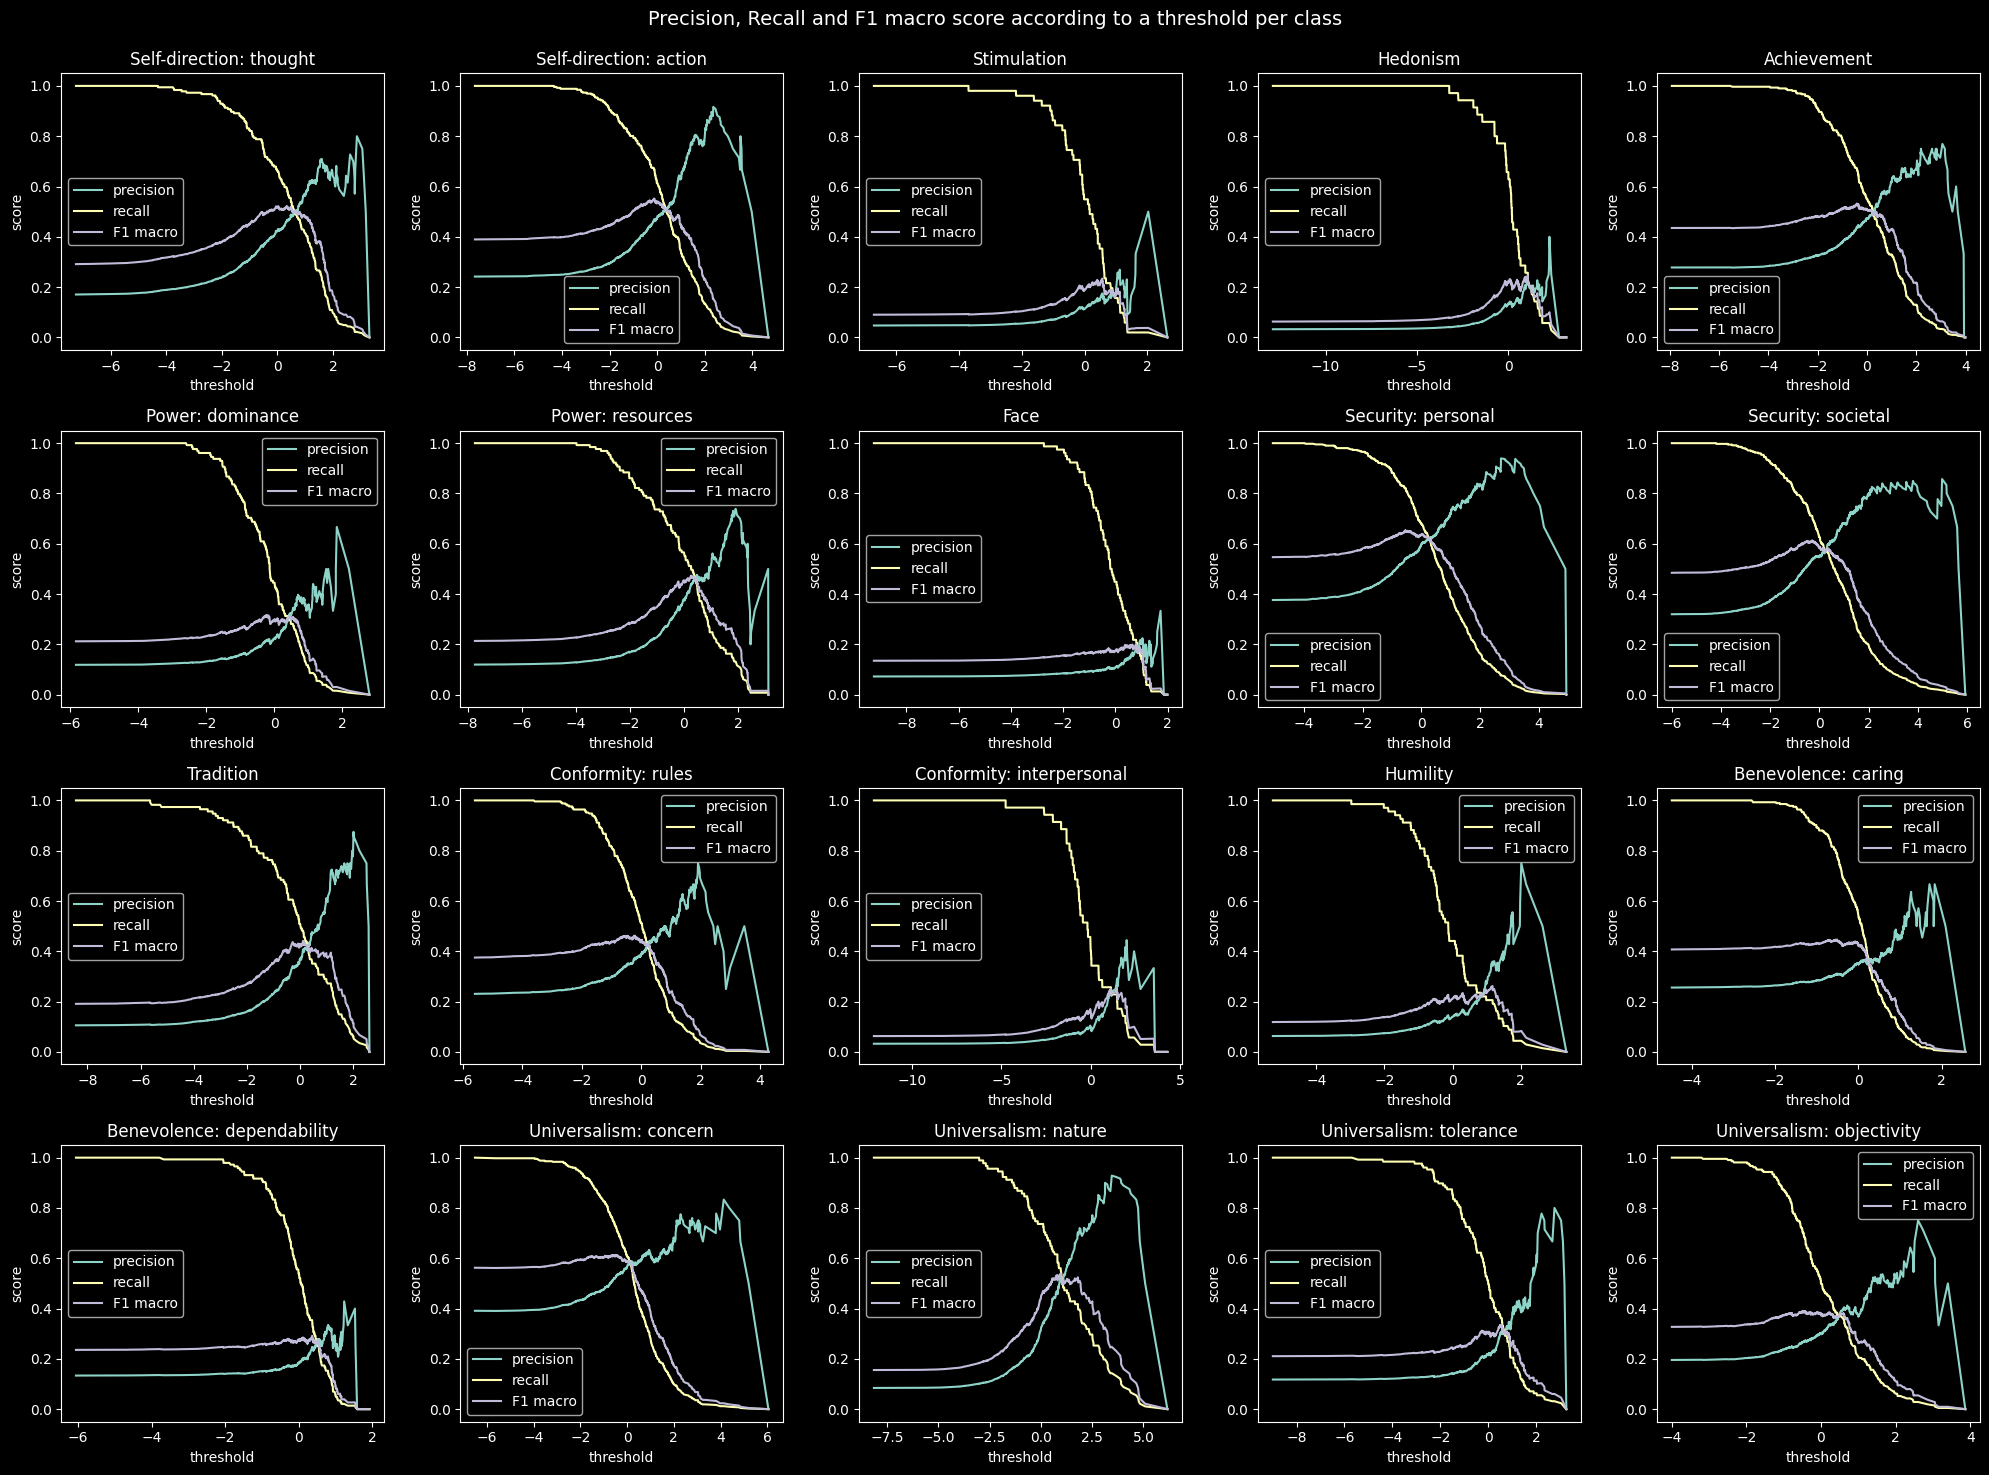

In [93]:
plt.figure(figsize=(20, 15))
plt.suptitle('Precision, Recall and F1 macro score according to a threshold per class\n', size=14)
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5, i + 1)
    ax.set_title(l)
    # TODO: Use sigmoid for threshold or not?
    ax.plot(s_preds[:,i], c_precision[:,i], label='precision')
    ax.plot(s_preds[:,i], c_recall[:,i], label='recall')
    ax.plot(s_preds[:,i], c_F1[:,i], label='F1 macro')
    ax.set_xlabel('threshold')
    ax.set_ylabel('score')
    #ax.set_xlim(0, 1)
    ax.legend()
plt.tight_layout()
plt.show()

In [94]:
import numpy as np

# Get the index of maximum F1 macro score for each target
idx_max = c_F1.argmax(0)
# Get the threshold for each target
thresholds_per_target = np.array([s_preds[idx, i] for i, idx in enumerate(idx_max)])

## Evaluation on the Validation set

In [95]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.389


In [96]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE,
                                         thresholds_per_target)

# Compute Validation F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with threshold',
      f'selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.411


In [97]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.46      0.59      0.52       184
    Self-direction: action       0.46      0.65      0.54       261
               Stimulation       0.18      0.37      0.25        51
                  Hedonism       0.22      0.26      0.24        35
               Achievement       0.44      0.67      0.53       300
          Power: dominance       0.22      0.56      0.31       128
          Power: resources       0.44      0.50      0.47       129
                      Face       0.17      0.19      0.18        78
        Security: personal       0.54      0.82      0.65       406
        Security: societal       0.54      0.71      0.61       345
                 Tradition       0.39      0.47      0.43       114
         Conformity: rules       0.36      0.58      0.45       249
 Conformity: interpersonal       0.26      0.17      0.21        35
 

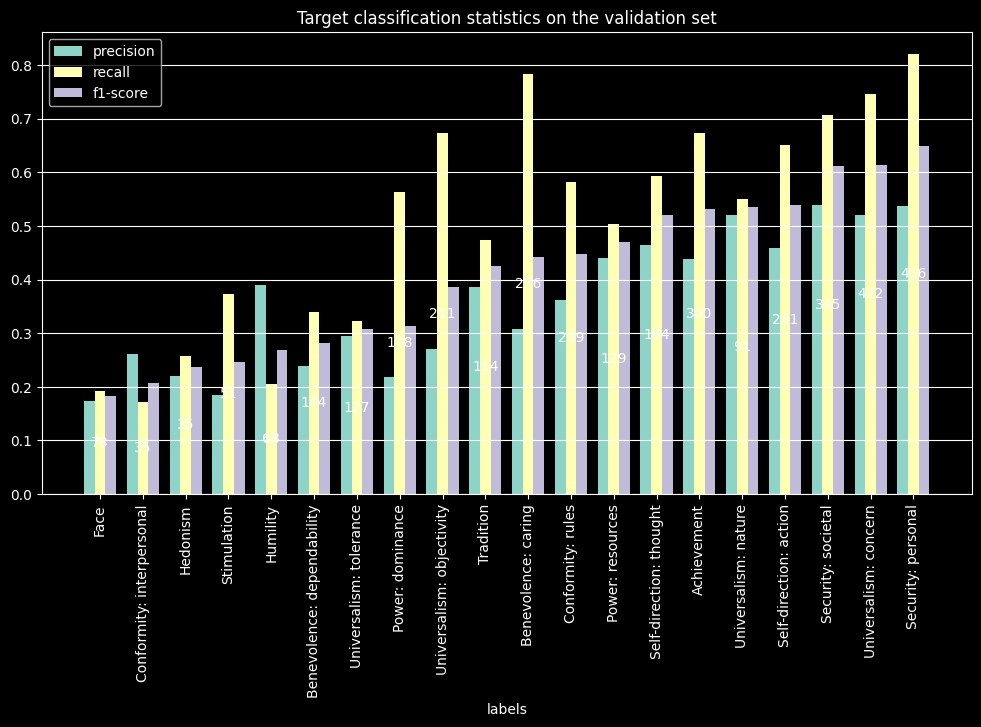

In [98]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')

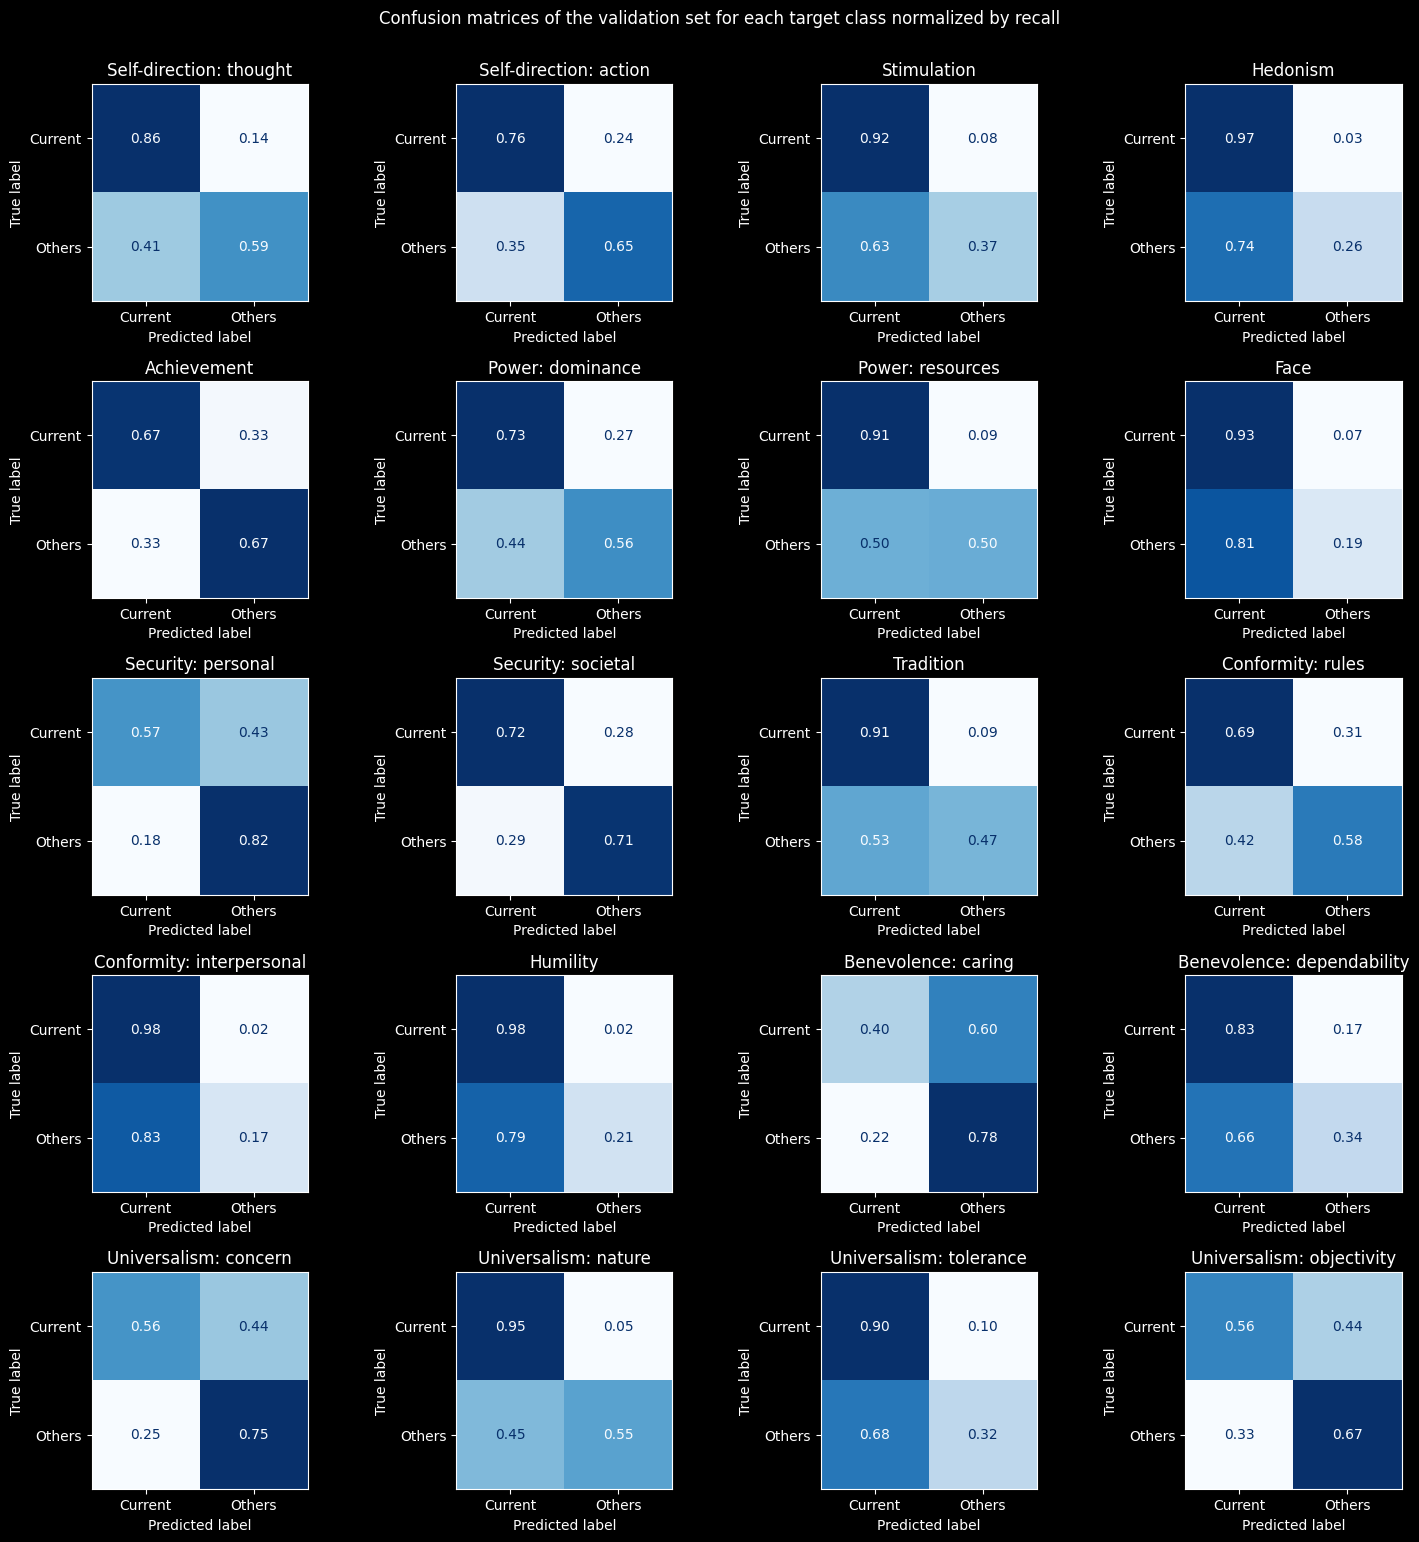

In [99]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation',
                        normalize_by='recall')

## Evaluation on the Test set

In [100]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.273


In [101]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.276


In [102]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.30      0.41      0.34       251
    Self-direction: action       0.40      0.54      0.46       496
               Stimulation       0.15      0.38      0.21       138
                  Hedonism       0.11      0.17      0.14       103
               Achievement       0.37      0.56      0.45       575
          Power: dominance       0.13      0.38      0.19       164
          Power: resources       0.16      0.32      0.21       132
                      Face       0.06      0.11      0.08       130
        Security: personal       0.45      0.73      0.56       759
        Security: societal       0.33      0.47      0.39       488
                 Tradition       0.13      0.24      0.17       172
         Conformity: rules       0.31      0.51      0.39       455
 Conformity: interpersonal       0.00      0.00      0.00        60
       

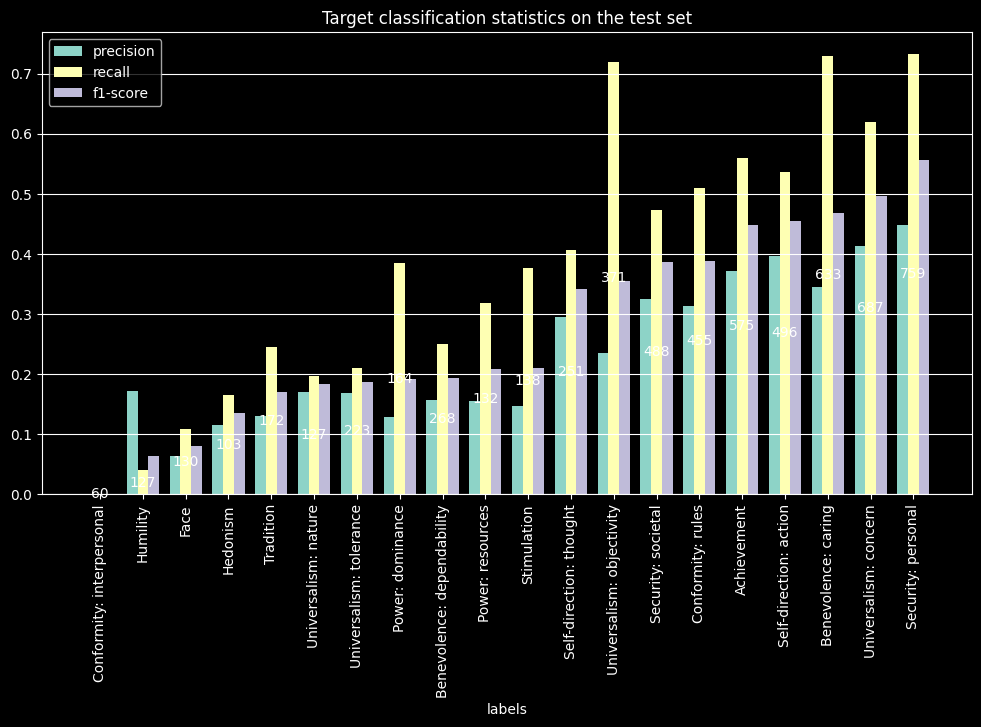

In [103]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')

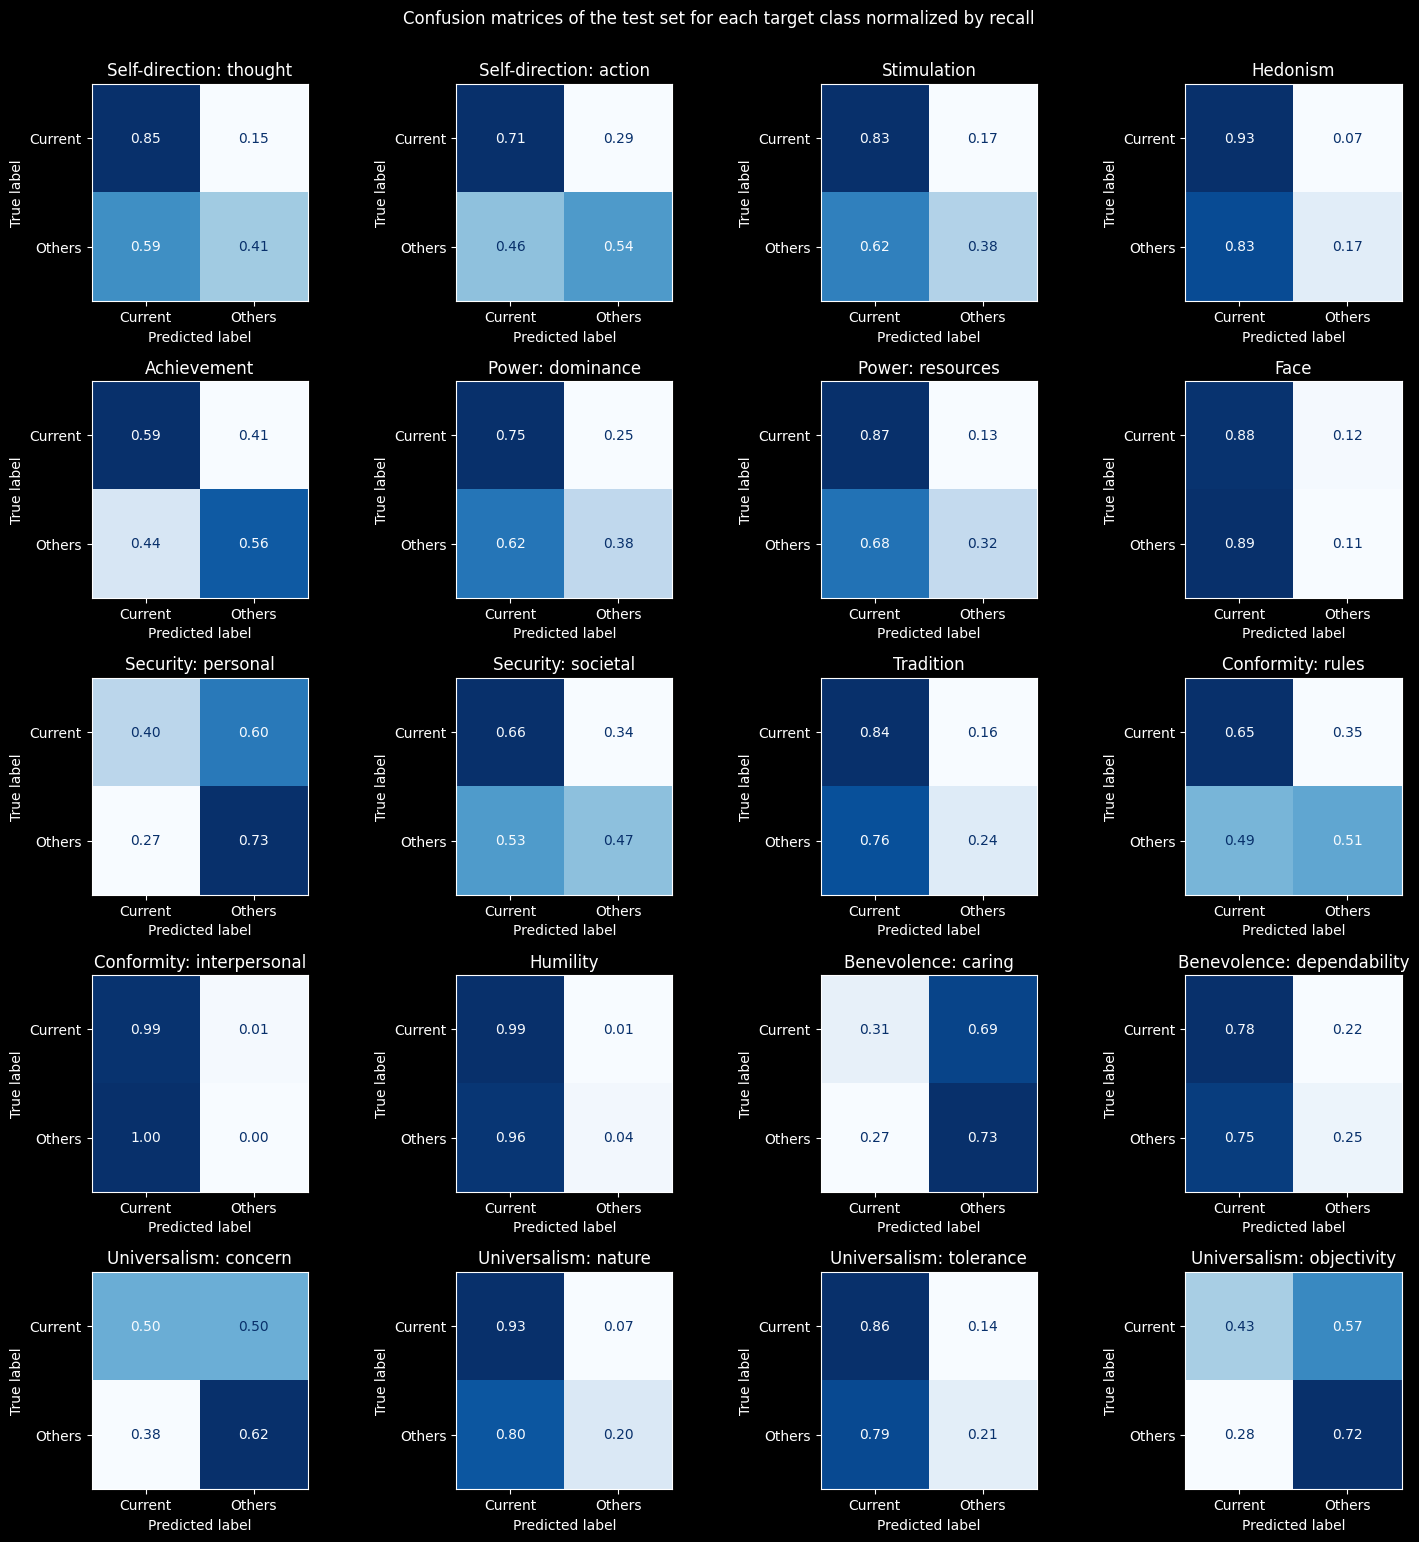

In [104]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test')

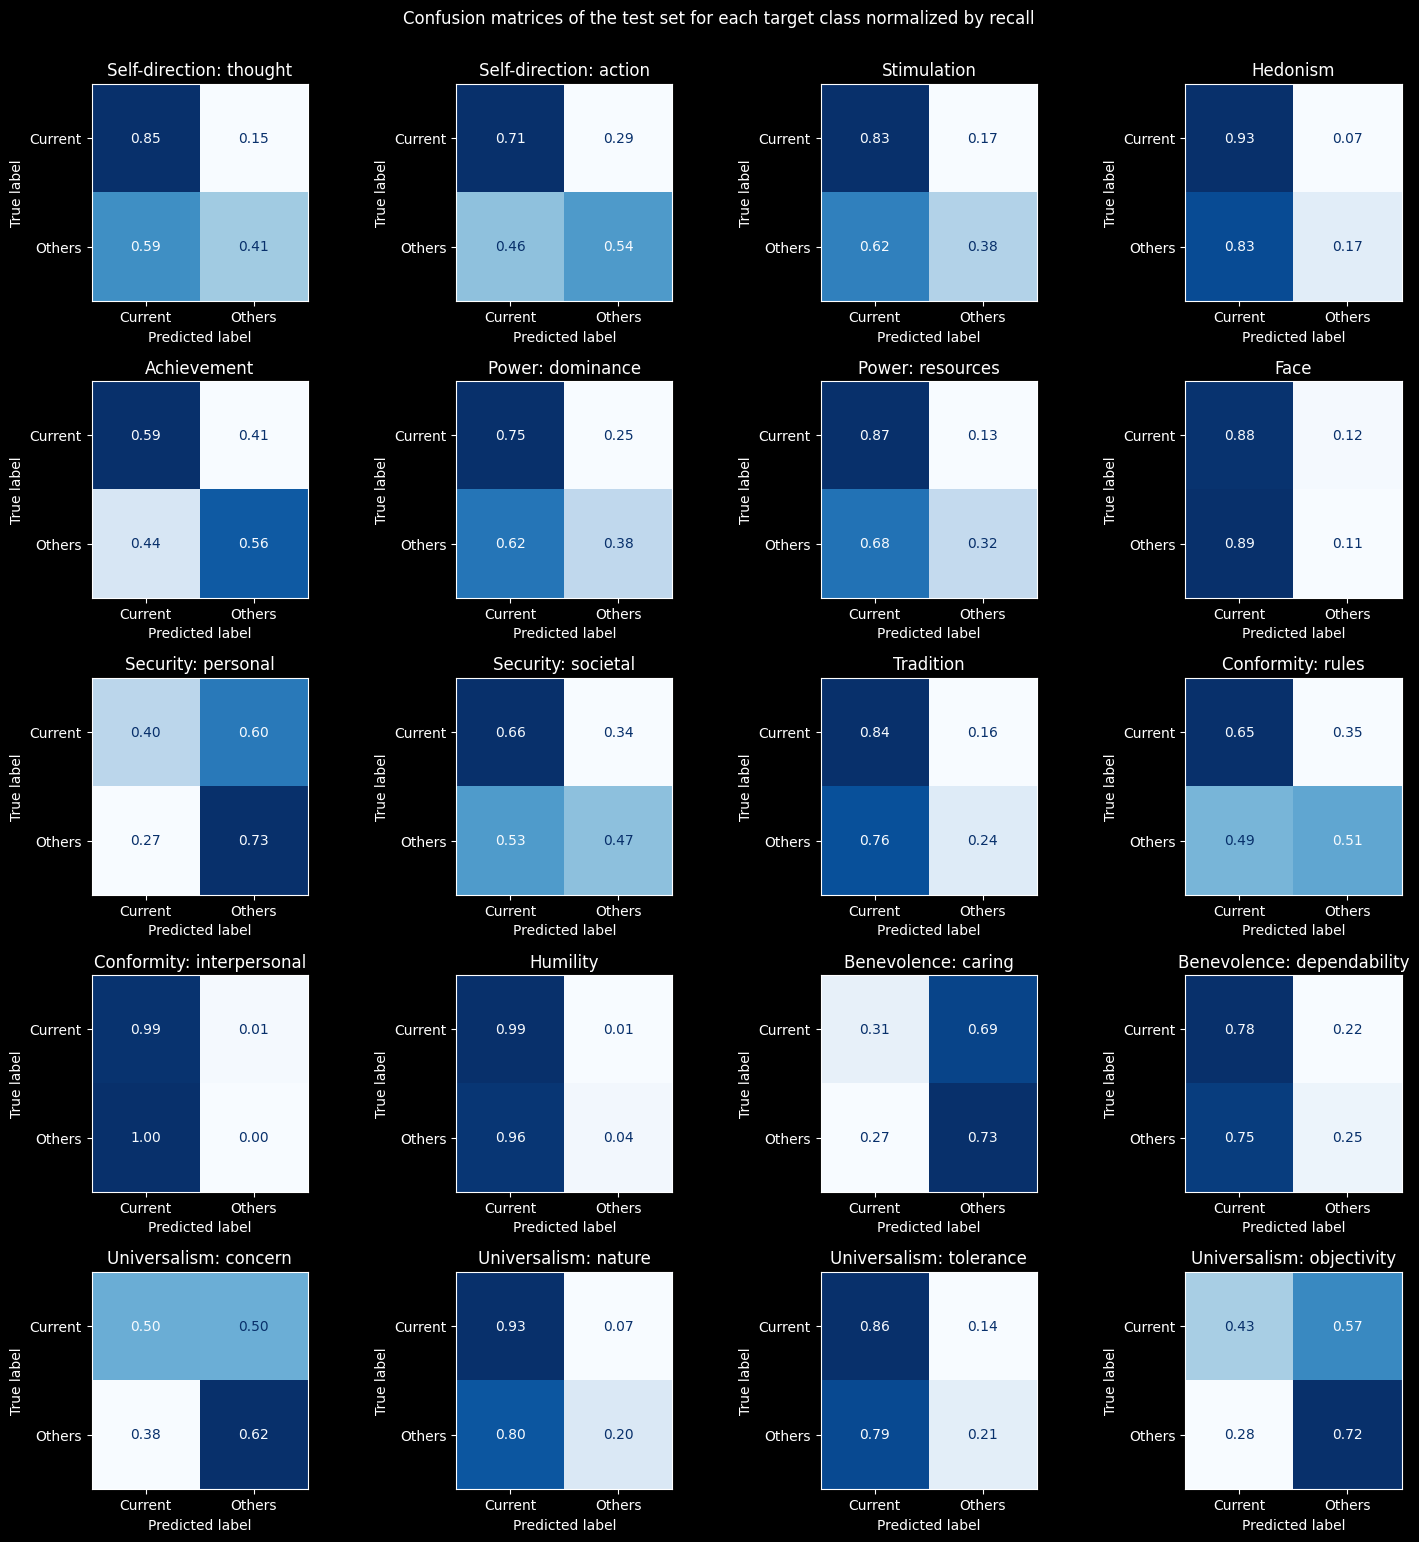

In [105]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')